# Make Canoeing Map
Make a canoeing map using OpenStreetMap data.
- get OSM data for desired using OSMNx
- get background tiles for map
- assembple it all together using Matplotlib


In [13]:
import pandas as pd
import json
import numpy as np
import geopandas as gpd
import contextily as cx
import geopy.distance
from shapely.geometry import MultiPolygon, Polygon, Point, LineString
import osmnx as ox
import pyproj
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import patches

%matplotlib inline

In [2]:

from src.map_utils import *

In [3]:
# Load nation lakes coords   
with open("nation_lakes.json") as f:
    lakes = json.load(f)
print("lakes:")
for i,lake in enumerate(lakes):
    print(i,lake["name"])

lakes:
0 Tsayta Lake
1 Indata Lake
2 Tchentlo Lake
3 Chuchi Lake


In [14]:
place = lakes[0]
place_name = place["name"].replace(" ", "-")
print(place["name"])

Tsayta Lake


In [15]:
with open("tags_osm.json") as f:
    desired_tags = json.load(f)
desired_tags

{'leisure': ['park', 'nature_reserve'],
 'tourism': ['camp_site'],
 'highway': ['motorway',
  'trunk',
  'primary',
  'secondary',
  'tertiary',
  'unclassified',
  'track',
  'road',
  'path',
  'footway'],
 'water': ['lake', 'river'],
 'barrier': ['yes'],
 'natural': ['spring'],
 'waterway': ['waterfall', 'weir', 'dam']}

In [16]:
# load settings from file
with open("tag_styles.json") as f:
    tag_styles = json.load(f)
tag_styles

{'tourism': {'camp_site': 'campsite'},
 'natural': {'peak': 'mountain',
  'mountain_range': 'mountain',
  'spring': 'point_of_interest'},
 'barrier': {'yes': 'barrier'},
 'water': {'lake': 'lake', 'river': 'river'},
 'highway': {'motorway': 'secondary_road',
  'trunk': 'secondary_road',
  'primary': 'secondary_road',
  'secondary': 'tertiary_road',
  'tertiary': 'tertiary_road',
  'unclassified': 'tertiary_road',
  'track': 'tertiary_road',
  'road': 'tertiary_road',
  'path': 'trail',
  'footway': 'trail'},
 'leisure': {'nature_reserve': 'park_boundary', 'park': 'park_boundary'},
 'waterway': {'waterfall': 'point_of_interest',
  'weir': 'barrier',
  'dam': 'barrier'}}

In [17]:
plot_dim = 10
styles = build_style_dict(plot_dim)
styles

{'main_road': {'color': 'gray', 'linewidth': 1.0},
 'secondary_road': {'color': 'gray', 'linewidth': 0.5},
 'tertiary_road': {'color': 'gray', 'linewidth': 0.25},
 'trail': {'color': 'gray', 'linewidth': 0.25, 'linestyle': '--'},
 'campsite': {'marker': 'o',
  'ms': 5.0,
  'mew': 0.5,
  'mfc': 'none',
  'mec': 'green',
  'alpha': 0.9,
  'linestyle': ''},
 'lake': {'color': 'blue', 'linewidth': 0.25, 'alpha': 0.8},
 'river': {'color': 'blue', 'linewidth': 0.25, 'alpha': 0.5},
 'mountain': {'marker': '+',
  'ms': 3.75,
  'color': 'black',
  'mew': 0.5,
  'mfc': 'none',
  'linestyle': ''},
 'point_of_interest': {'marker': '*',
  'ms': 3.75,
  'mfc': 'none',
  'mec': 'purple',
  'mew': 0.5,
  'alpha': 0.5,
  'linestyle': ''},
 'barrier': {'marker': 'x',
  'ms': 3.75,
  'mfc': 'none',
  'mec': 'red',
  'mew': 1,
  'alpha': 0.5,
  'linestyle': ''},
 'park_boundary': {'color': 'green',
  'linewidth': 1.0,
  'linestyle': '--',
  'alpha': 0.5}}

In [18]:
gdf = ox.features.features_from_bbox(place["north"], place["south"], place["east"], place["west"], desired_tags)
gdf = gdf.to_crs(epsg=3857) # project to spherical mercator to match tiles
gdf.reset_index(inplace=True)
cols_to_keep = ['element_type', 'geometry', 'name'] + [key for key in desired_tags.keys() if key in gdf.columns]
gdf = gdf[cols_to_keep]
elements = gdf.to_dict(orient = "records")
gdf

,element_type,geometry,name,leisure,tourism,highway,water,natural,waterway
0,node,POINT (-13954643.065 7449910.188),NaN,NaN,camp_site,NaN,NaN,NaN,NaN
1,node,POINT (-13955949.355 7450868.038),Kwanila Beach,NaN,camp_site,NaN,NaN,NaN,NaN
2,node,POINT (-13964918.767 7450925.500),Big Island,NaN,camp_site,NaN,NaN,NaN,NaN
3,node,POINT (-13968879.459 7449976.162),Andrew Bay,NaN,camp_site,NaN,NaN,NaN,NaN
4,node,POINT (-13971662.691 7451464.295),NaN,NaN,camp_site,NaN,NaN,NaN,NaN
5,node,POINT (-13984411.856 7453967.306),NaN,NaN,camp_site,NaN,NaN,NaN,NaN
6,way,"LINESTRING (-13998631.419 7455745.205, -139986...",Driftwood Forest Service Road,NaN,NaN,tertiary,NaN,NaN,NaN
7,way,"LINESTRING (-13989579.407 7454466.128, -139895...",Fall-Tsayta Forest Service Road,NaN,NaN,unclassified,NaN,NaN,NaN
8,way,"LINESTRING (-13986980.131 7454231.325, -139869...",NaN,NaN,NaN,track,NaN,NaN,NaN
9,way,"LINESTRING (-13984530.846 7453873.273, -139845...",Fall-Tsayta Forest Service Road,NaN,NaN,unclassified,NaN,NaN,NaN


# Get background tiles

In [19]:
west,east,south,north = place["west"], place["east"], place["south"], place["north"]
zoom_level = cx.tile._calculate_zoom(west,south,east,north) + 1  


STAMEN_API_KEY = os.environ["STAMEN_API_KEY"]
with open("tiles.json") as f:
    tiles = json.load(f)
print(tiles.keys())
tiles_source = tiles["StamenTonerLite"].replace("API_KEY", STAMEN_API_KEY)

# save tile locally if desired
# img, ext = cx.bounds2raster(west,south, east, north, f"cache/{place_name}.tif", zoom_level, source=tiles_source, ll=True)


dict_keys(['StamenToner', 'StamenTonerLite', 'StamenTerrain', 'StamenWatercolor', 'GoogleMaps', 'GoogleSatellite', 'GoogleSatelliteHybrid', 'EsriSatellite'])


In [20]:
# convert to EPSG3857
x_min, y_min = lonlat_to_xy(west, south)
x_max, y_max = lonlat_to_xy(east, north) 
dy = y_max - y_min
dx = x_max - x_min

plot_dim = 10
styles = build_style_dict(plot_dim)
figsize = calculate_plot_dimensions(plot_dim, dx, dy)
annotation_text_size = plot_dim * 0.5

figsize

(10, 3.4472528677410468)

In [21]:
annotation_text_size = plot_dim * 0.5

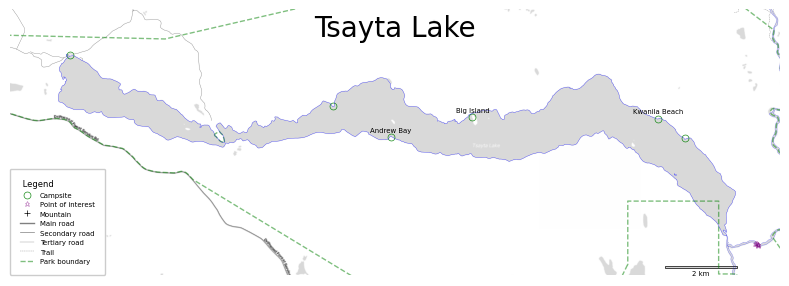

In [22]:
# make fig with backgound tiles
fig,ax = plt.subplots(1, figsize=figsize,linewidth=1)
ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
ax.set_axis_off() # don't display axes with coordinates

cx.add_basemap(ax, source = tiles_source, zoom=zoom_level);

# Plot features from OSM
for element in elements:
    # get coordinates to plot for this element
    element_type = element["element_type"]
    coords_list = extract_coords(element["geometry"])
    for coords in coords_list:
        x,y = zip(*coords)
        ax.plot(x,y,**get_style(element, tag_styles, styles))
    if (element_type == "node" and type(element["name"])!=float):
        ax.annotate(element["name"], (x[0],y[0]), 
                    size=annotation_text_size, 
                    xycoords='data', 
                    xytext=(0, annotation_text_size*0.75), 
                    textcoords='offset points', 
                    ha='center');
# Add legend
legend_items = ["campsite", "point_of_interest", "mountain", "main_road", "secondary_road", "tertiary_road", "trail", "park_boundary"]
legend_styles = {name: styles[name] for name in legend_items}
legend_loc = (0.,0)
ax = add_legend(ax, annotation_text_size, legend_styles, legend_loc)

# Add distance scale bar
plot_width_km = get_plot_width_km(west, east, south, north)
scale_max_width_pct = 0.15

scale_anchor_fig_x = 1-scale_max_width_pct
scale_anchor_fig_y = 0.025
scale_anchor_xy = fig_to_xy(scale_anchor_fig_x, scale_anchor_fig_y,x_min,x_max,y_min,y_max)

ax = add_scale_bar(ax, scale_max_width_pct, scale_anchor_xy, plot_width_km, dx, dy, annotation_text_size)

# Add map title
ax.annotate(place["name"], fig_to_xy(0.5, 0.9, x_min, x_max, y_min, y_max), ha='center', va = "baseline", size=annotation_text_size*4);
# plt.tight_layout(pad=1)
# plt.savefig(f'maps/{place_name}.png', dpi=500, bbox_inches='tight', edgecolor=fig.get_edgecolor()) 